In [14]:
import os
import glob
import collections
import subprocess as sp
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from operator import itemgetter
from networkx.classes.multidigraph import MultiDiGraph
from networkx.drawing.nx_agraph import read_dot, write_dot, graphviz_layout

import stats
import graphs
import sqlite_helper as helper

In [15]:
# Needs to be done when there are changes in these files ...
import importlib
importlib.reload(helper)
importlib.reload(stats)
importlib.reload(graphs)

<module 'graphs' from '/Users/christopher/Uni/MasterThesis/repositories/masters-thesis/src/graphs.py'>

# Methods

In [28]:
def bootstrap_mean(data: list[float], num_iterations: int=10000, alpha: float=0.05):

    bootstrap_means = np.empty(num_iterations)

    for i in range(num_iterations):
        # Resample the data with replacement
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)

        bootstrap_mean = np.mean(bootstrap_sample)

        bootstrap_means[i] = bootstrap_mean

    lower_percentile = (1 - alpha) / 2
    upper_percentile = 1 - lower_percentile
    lower_bound = np.percentile(bootstrap_means, lower_percentile * 100)
    upper_bound = np.percentile(bootstrap_means, upper_percentile * 100)

    # Return the confidence interval
    return lower_bound, upper_bound

In [29]:
def check_confidence_interval_overlap(ci1: tuple[float, float], ci2: tuple[float, float]):
    if ci1[1] >= ci2[0]:
        if ci1[0] <= ci2[1]:
            return True
    return False

In [77]:
def check_percentage_difference(num1, num2, threshold=3):
    difference = abs(num1 - num2)
    percentage_difference = (difference / num1) * 100

    if percentage_difference > threshold:
        return True
    else:
        return False

In [74]:
def get_change(current, previous):
    if current == previous:
        return 100.0
    try:
        return (abs(current - previous) / previous) * 100.0
    except ZeroDivisionError:
        return 0


In [76]:
print(check_percentage_difference(60.1, 60.3))
print(check_percentage_difference(100, 200))
print(get_change(100, 60.3))

Percentage difference: 0.33277870216305444
True
Percentage difference: 100.0
True
65.8374792703151


In [30]:
def plot_confidence_intervals(ci1, ci2):
    # Create figure and axes
    fig, ax = plt.subplots()

    # Set y-axis limits
    ax.set_ylim(0, 1)

    # Plot confidence intervals
    ax.plot(ci1, [0.5, 0.5], 'b', lw=2, label='CI 1')
    ax.plot(ci2, [0.6, 0.6], 'r', lw=2, label='CI 2')

    # Add legend
    ax.legend(loc='lower right')

    # Show the plot
    plt.show()

In [42]:
def calculate_middle_value(interval):
    lower_bound, upper_bound = interval
    middle_value = (lower_bound + upper_bound) / 2
    return middle_value

In [51]:
def remove_outliers(data, threshold=1.5):
    # Calculate the quartiles and IQR
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    
    # Calculate the lower and upper bounds for outliers
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    
    # Remove outliers outside the bounds
    filtered_data = [x for x in data if lower_bound <= x <= upper_bound]
    
    return filtered_data

# Data

In [16]:
db_path = "/Users/christopher/Uni/MasterThesis/experiment_4_roaring/measurements.db"

In [17]:
measurements = helper.get_all_measurements(db_path)

In [18]:
grouped_by_tag = helper.group_measurements_by_property(measurements, -2)

In [19]:
for tag in grouped_by_tag.keys():
    grouped_by_tag[tag] = helper.group_measurements_by_property(grouped_by_tag[tag], -3)

Benchmark BenchmarkShortIteratorNextArray/init_size_65535_shortIterator_next number of measurements: 135 and 135


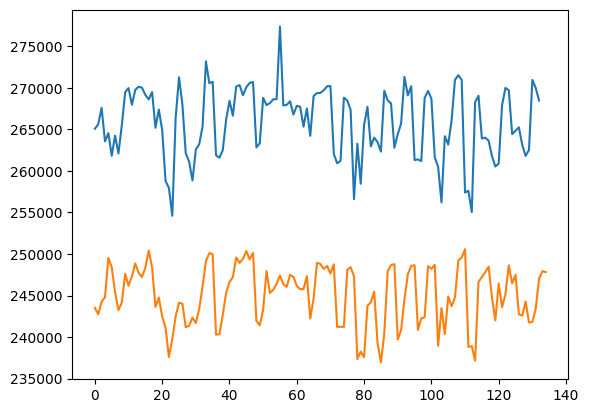

Benchmark BenchmarkShortIteratorNextArray/init_size_650_shortIterator_next number of measurements: 129 and 129


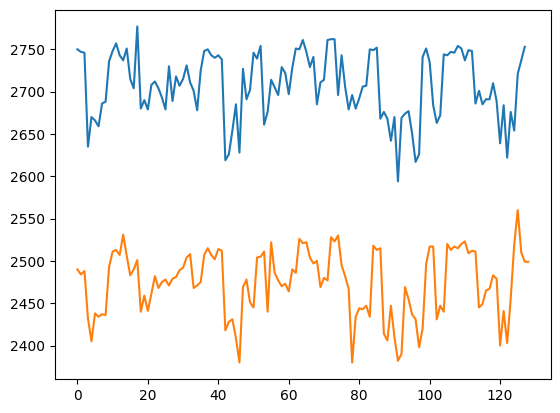

Benchmark BenchmarkUnionBitset number of measurements: 123 and 123


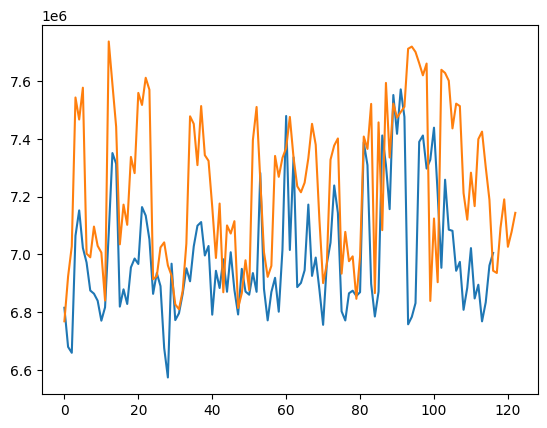

Benchmark BenchmarkChecksum/checksum-compressed-32 number of measurements: 132 and 132


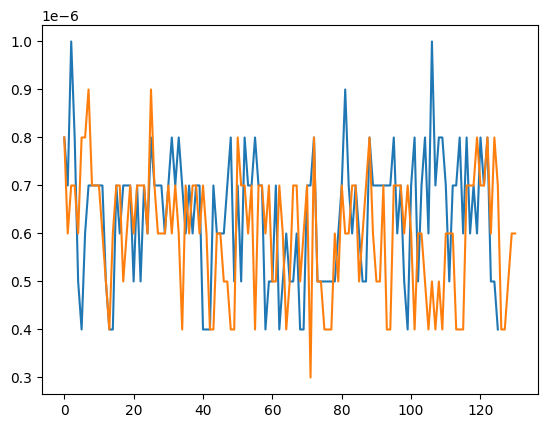

Benchmark BenchmarkShortIteratorNextBitmap/init_size_650_shortIterator_next number of measurements: 132 and 132


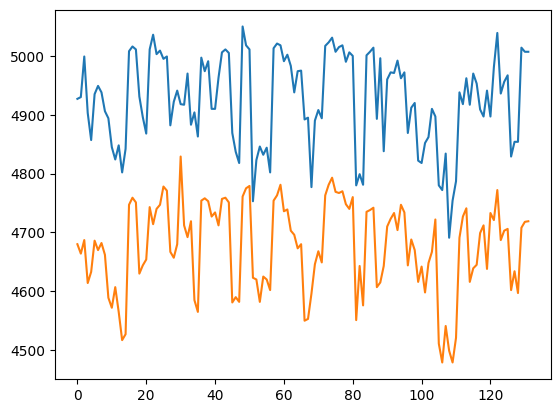

Benchmark BenchmarkUnionInPlaceCopyOnWrite/10-7-3-3 number of measurements: 135 and 135


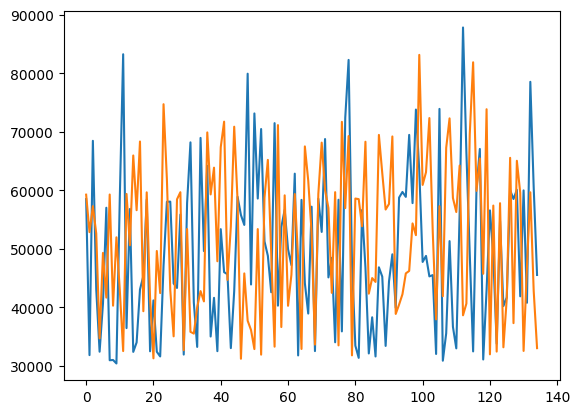

Benchmark BenchmarkChecksum/checksum-32 number of measurements: 132 and 132


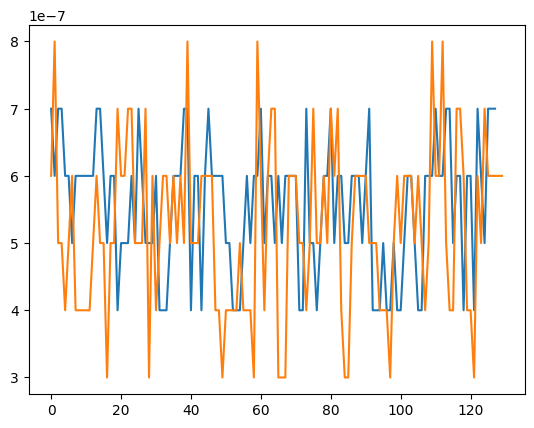

Benchmark BenchmarkChecksum/checksum-64 number of measurements: 132 and 132


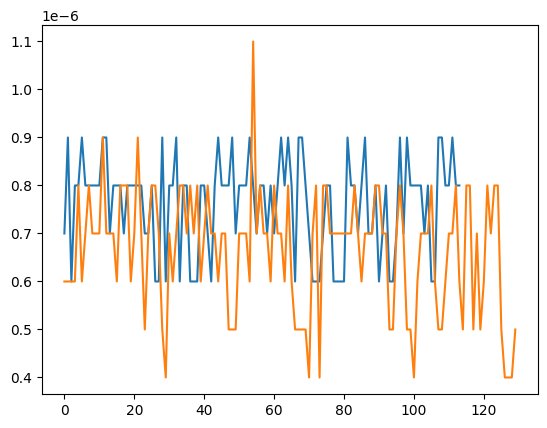

Benchmark BenchmarkChecksum/checksum-compressed-64 number of measurements: 126 and 126


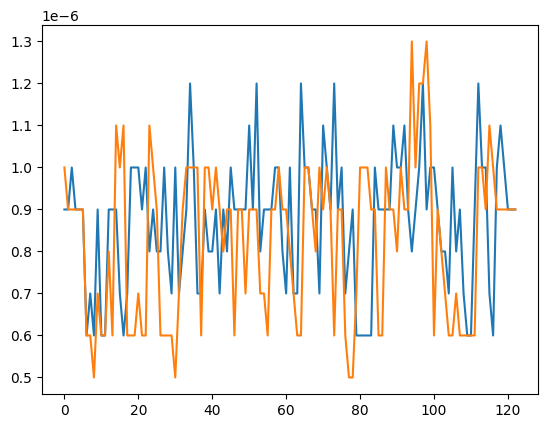

Benchmark BenchmarkShortIteratorNextBitmap/init_size_1_shortIterator_next number of measurements: 132 and 132


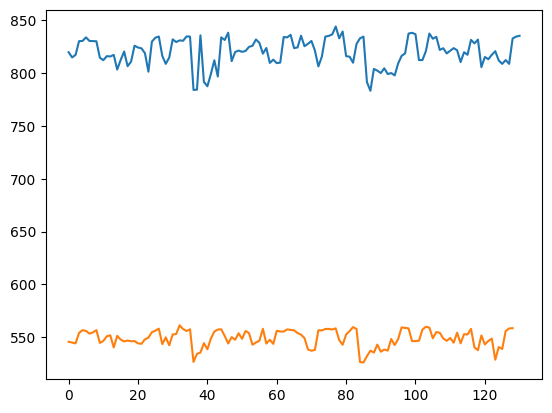

Benchmark BenchmarkIterateRoaring/iterator-compressed number of measurements: 135 and 135


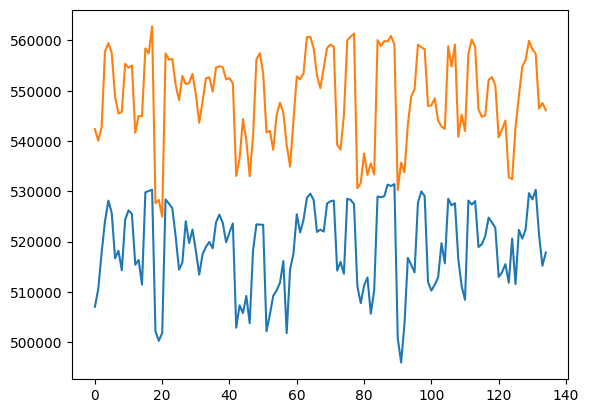

Benchmark BenchmarkIterateRoaring/iterate-compressed number of measurements: 132 and 132


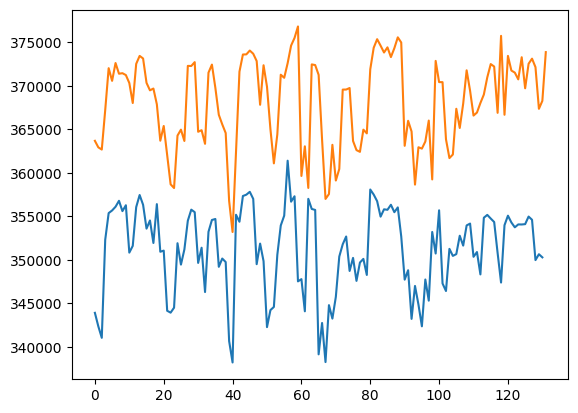

Benchmark BenchmarkSparseIterateRoaring number of measurements: 129 and 129


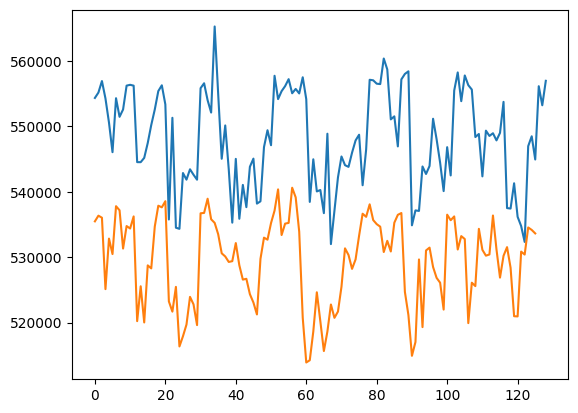

Benchmark BenchmarkIterateRoaring/iterator number of measurements: 129 and 129


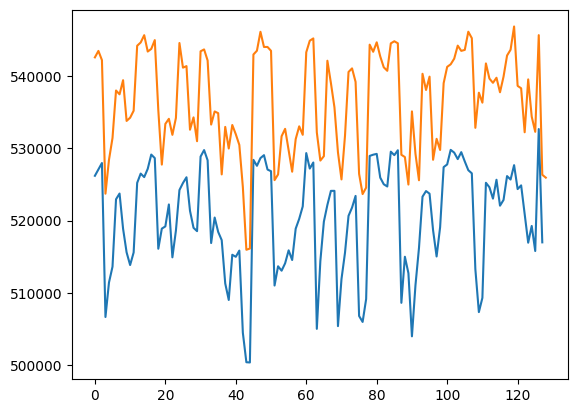

Benchmark BenchmarkUnionInPlaceCopyOnWrite/10-4-3-3 number of measurements: 129 and 129


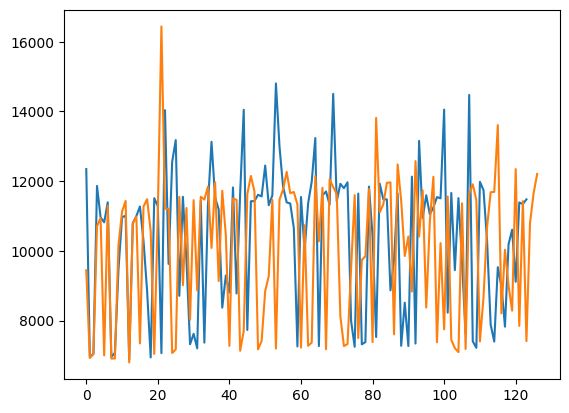

Benchmark BenchmarkChecksum/checksum-16 number of measurements: 123 and 123


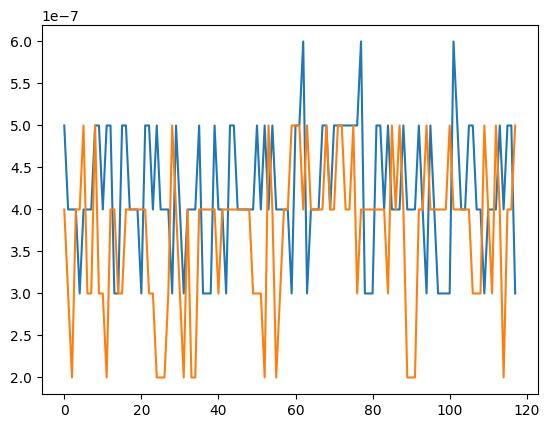

Found 16 benchmarks with non-overlapping confidence intervals


In [83]:
count = 0
for benchmark in list(grouped_by_tag["v1.2.0"].keys())[0:100]:
    ns_per_op1 = [x[2] for x in grouped_by_tag["v1.2.0"][benchmark]]
    ns_per_op2 = [x[2] for x in grouped_by_tag["v1.2.3"][benchmark]]

    clean_ns_per_op1 = remove_outliers(ns_per_op1, threshold=1.5)
    clean_ns_per_op2 = remove_outliers(ns_per_op2, threshold=1.5)
    
    c1 = bootstrap_mean(clean_ns_per_op1, num_iterations=10000, alpha=0.01)
    c2 = bootstrap_mean(clean_ns_per_op2, num_iterations=10000, alpha=0.01)

    if check_confidence_interval_overlap(c1, c2) == False and check_percentage_difference(np.mean(clean_ns_per_op1), np.mean(clean_ns_per_op2), threshold=3) == True:
        # plot_confidence_intervals(c1, c2)
        print(f"Benchmark {benchmark} number of measurements: {len(ns_per_op1)} and {len(ns_per_op2)}")
        plt.plot(clean_ns_per_op1)
        plt.plot(clean_ns_per_op2)
        plt.show()

        count += 1

print(f"Found {count} benchmarks with non-overlapping confidence intervals")

# Quantifiying Performance Changes

In [12]:
import numpy as np

In [1]:
bench_change = "BenchmarkShortIteratorNextArray/init_size_65535_shortIterator_next"
bench_no_change = "BenchmarkEvenIntervalArrayUnions"
bench_small_change = "BenchmarkAndAny/small-filters_and-first"

In [10]:
def calculate_confidence_interval(benchmark, tag1, tag2):
    y = [x[2] for x in grouped_by_tag[tag1][benchmark]]
    X = [x[2] for x in grouped_by_tag[tag2][benchmark]]
    
    y_mean = np.mean(y)

In [11]:
calculate_confidence_interval(bench_change, "v1.2.0", "v1.2.3")

(0.02769338467007766, 0.037585656847388044)

In [ ]:
#1 bootstrapping
# Draw 10000 random samples of 45 values with replacement
# Determine median value of each sample
# Order them
# Use the top and bottom 0,5% medians as confidence interval
# for 99% CI

def bootstrap(samples: list[float], num_iterations: int = 10000, alpha=0.05, sample_size: int = 100) -> list[float]:
    # Draw 10000 random samples of 45 values
    simulated_means: list[float] = []
    for i in range(num_iterations):
        simulated_samples = []

        for j in range(sample_size):
            simulated_samples.append(np.random.choice(samples))
        
        simulated_means.append(np.mean(simulated_samples))

    # [] TODO Percentiles vs quantile ?
    lower = np.percentile(simulated_means, alpha/2)
    upper = np.percentile(simulated_means, 1 - alpha/2)

In [13]:

def bootstrap_mean(data: list[float], num_iterations: int=10000, alpha: float=0.05):

    bootstrap_means = np.empty(num_iterations)

    for i in range(num_iterations):
        # Resample the data with replacement
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)

        bootstrap_mean = np.mean(bootstrap_sample)

        bootstrap_means[i] = bootstrap_mean

    lower_percentile = (1 - alpha) / 2
    upper_percentile = 1 - lower_percentile
    lower_bound = np.percentile(bootstrap_means, lower_percentile * 100)
    upper_bound = np.percentile(bootstrap_means, upper_percentile * 100)

    # Return the confidence interval
    return lower_bound, upper_bound

In [23]:
lower_bound, upper_bound = bootstrap_mean(ns_per_op1)

print("Bootstrap Confidence Interval for Mean:")
print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)

Bootstrap Confidence Interval for Mean:
Lower Bound: 5.682926829268291e-07
Upper Bound: 5.723577235772356e-07


In [24]:
lower_bound, upper_bound = bootstrap_mean(ns_per_op2)

print("Bootstrap Confidence Interval for Mean:")
print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)

Bootstrap Confidence Interval for Mean:
Lower Bound: 4.016260162601626e-07
Upper Bound: 4.040650406504065e-07


In [25]:
def check_confidence_interval_overlap(ci1: tuple[float, float], ci2: tuple[float, float]):
    if ci1[1] >= ci2[0]:
        if ci1[0] <= ci2[1]:
            return True
    return False

In [26]:
c1 = bootstrap_mean(ns_per_op1)